<a href="https://colab.research.google.com/github/tujiaqi2002/DL_lab1/blob/main/Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1-ItLd1aB4hkafZTheNFw_3kdGWPmn3x3?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch










Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

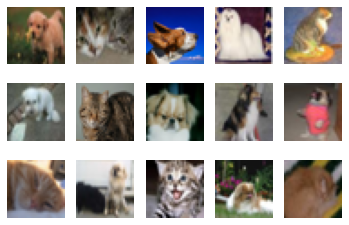

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [5]:
print("number of training examples:", len(train_loader.dataset))
print("number of validation examples:", len(val_loader.dataset))
print("number of test examples:", len(test_loader.dataset))

number of training examples: 50000
number of validation examples: 50000
number of test examples: 10000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [6]:
# The validation set is used to assess the model's performance on data it hasn't seen before,
# during the training process. This is done to prevent overfitting, 
# which is when the model becomes too specialized for the training set and does not perform well on new data.

# If we evaluate the model using the training set loss or error instead of the validation set,
# we cannot accurately determine if the model is overfitting.
# The model may have a low training set loss or error but a high validation set loss or error, indicating poor performance on new data.

# It's therefore crucial to use the validation set to determine the model's performance on unseen data,
# and make adjustments to prevent overfitting and improve its ability to generalize to new data.













## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [7]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [10]:
for param in small_net.parameters():
    print(param.shape)
print()
for param in large_net.parameters():
    print(param.shape)

# Total number of parameters in small_net = 5*3*3*3 + 5 + 1*245 + 1 = 386
# Total number of parameters in large_net =  5*3*5*5+5 + 10*5*5*5 + 10 + 32*250 + 32 + 1*32 + 1 = 9705


torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [11]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [12]:
# batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [13]:
train_net(small_net,num_epochs=5)

# model_small_bs64_lr0.01_epoch4_train_err.csv: 
# This file contains the training error at till last epoch. It is saved as a CSV file and can be used for later plotting or analysis.

# model_small_bs64_lr0.01_epoch4_train_loss.csv: 
# This file contains the training loss at till last epoch. It is saved as a CSV file and can be used for later plotting or analysis.

# model_small_bs64_lr0.01_epoch4_val_err.csv: 
# This file contains the validation error till last epoch. It is saved as a CSV file and can be used for later plotting or analysis.

# model_small_bs64_lr0.01_epoch4_val_loss.csv: 
# This file contains the validation loss at till last epoch. It is saved as a CSV file and can be used for later plotting or analysis.

# model_small_bs64_lr0.01_epoch0
# model_small_bs64_lr0.01_epoch1
# model_small_bs64_lr0.01_epoch2
# model_small_bs64_lr0.01_epoch3
# model_small_bs64_lr0.01_epoch4
# These are the check point saving files for each epoch

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4285, Train loss: 0.6769766221046448 |Validation err: 0.389, Validation loss: 0.6600559242069721
Epoch 2: Train err: 0.37875, Train loss: 0.6551145000457763 |Validation err: 0.3975, Validation loss: 0.6676493976265192
Epoch 3: Train err: 0.359, Train loss: 0.6360841150283814 |Validation err: 0.3505, Validation loss: 0.6245929300785065
Epoch 4: Train err: 0.33825, Train loss: 0.6177050528526307 |Validation err: 0.355, Validation loss: 0.626868974417448
Epoch 5: Train err: 0.33025, Train loss: 0.6087089619636535 |Validation err: 0.334, Validation loss: 0.6187982093542814
Finished Training
Total time elapsed: 17.55 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [14]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
train_net(small_net)
train_net(large_net)
# small_net is faster, because it has less parameters.



Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.31875, Train loss: 0.6000257275104522 |Validation err: 0.3365, Validation loss: 0.6169636137783527
Epoch 2: Train err: 0.316125, Train loss: 0.5948834710121155 |Validation err: 0.3465, Validation loss: 0.6316888276487589
Epoch 3: Train err: 0.310125, Train loss: 0.5926671454906464 |Validation err: 0.3275, Validation loss: 0.6103320345282555
Epoch 4: Train err: 0.312625, Train loss: 0.5887359559535981 |Validation err: 0.3395, Validation loss: 0.6214236281812191
Epoch 5: Train err: 0.307375, Train loss: 0.5870595955848694 |Validation err: 0.3295, Validation loss: 0.6162877287715673
Epoch 6: Train err: 0.3045, Train loss: 0.5825400495529175 |Validation err: 0.331, Validation loss: 0.6156747937202454
Epoch 7: Train err: 0.303625, Train loss: 0.5822634224891663 |Validation err: 0.328, Validation loss: 0.611066865734756
Epoch 8: Train err: 0.302625, Train loss: 0.5788608641624451 |Validation err

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Training curve of small network:


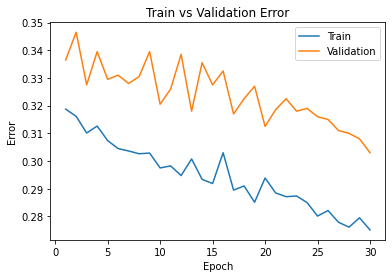

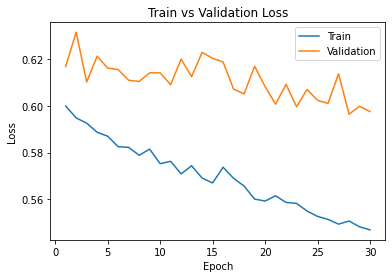

Training curve of large network:


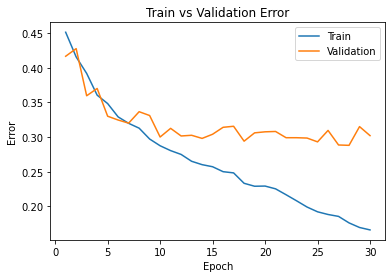

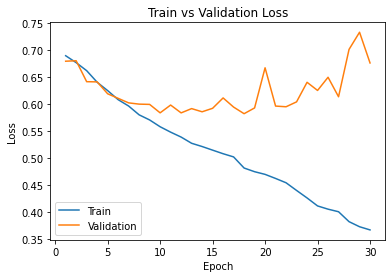

In [16]:
print("Training curve of small network:")
small_net_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_net_path)
print("Training curve of large network:")
large_net_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [17]:
# For small net, the model is underfitting. Since the trainning error goes down, but the validation error only decrease a bit.
# which is sign of underfitting

# For large net, the model is underfitting initially and error and loss goes down as the epoch increase.
# The model is later on overfitting, since it have low trining error but high validation error which is sign of overfitting.
# another reason is that the loss increase while the error of validation stays constantly.

# And in general the small net gets a lower validation error and loss.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6955151104927063 |Validation err: 0.509, Validation loss: 0.6958169676363468
Epoch 2: Train err: 0.49775, Train loss: 0.6941926484107971 |Validation err: 0.509, Validation loss: 0.6944976765662432
Epoch 3: Train err: 0.49775, Train loss: 0.6935118799209594 |Validation err: 0.509, Validation loss: 0.6939930655062199
Epoch 4: Train err: 0.49775, Train loss: 0.6931244301795959 |Validation err: 0.509, Validation loss: 0.693643344566226
Epoch 5: Train err: 0.49775, Train loss: 0.6928350505828857 |Validation err: 0.509, Validation loss: 0.6931493822485209
Epoch 6: Train err: 0.49775, Train loss: 0.6925878925323486 |Validation err: 0.509, Validation loss: 0.6927516013383865
Epoch 7: Train err: 0.497125, Train loss: 0.692349112033844 |Validation err: 0.507, Validation loss: 0.692528422921896
Epoch 8: Train err: 0.4795, Train loss: 0.6920542912483215 |Validation err: 0.5015, Va

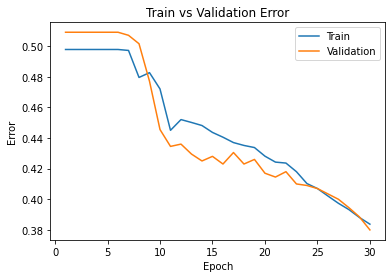

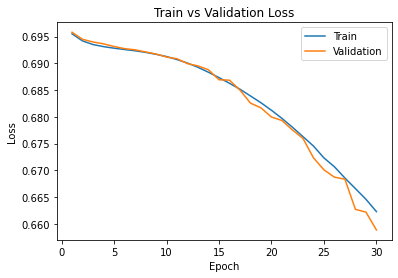

In [20]:
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
large_net_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_net_path)

# almost the same training time.
# higher error and higher loss in training data.
# however the the model is not overfitting anymore.
# which seems like 0.001 is too flow for this mode.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4275, Train loss: 0.6742977557182313 |Validation err: 0.3765, Validation loss: 0.637031726539135
Epoch 2: Train err: 0.368375, Train loss: 0.6400856471061707 |Validation err: 0.355, Validation loss: 0.6248273365199566
Epoch 3: Train err: 0.357, Train loss: 0.6258103721141816 |Validation err: 0.3435, Validation loss: 0.6111582862213254
Epoch 4: Train err: 0.348625, Train loss: 0.6193035736083984 |Validation err: 0.3445, Validation loss: 0.6090600341558456
Epoch 5: Train err: 0.330875, Train loss: 0.6069964549541473 |Validation err: 0.3205, Validation loss: 0.5968910921365023
Epoch 6: Train err: 0.31825, Train loss: 0.5847644207477569 |Validation err: 0.3175, Validation loss: 0.6014995649456978
Epoch 7: Train err: 0.310125, Train loss: 0.5844504678249359 |Validation err: 0.32, Validation loss: 0.5886365948244929
Epoch 8: Train err: 0.298875, Train loss: 0.5663281772136688 |Validation err: 0.

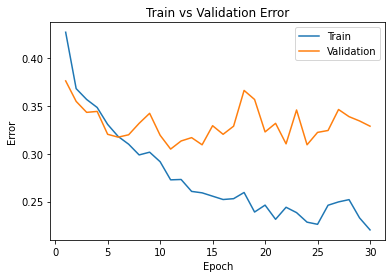

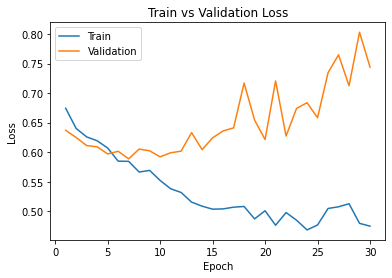

In [21]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
large_net_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_net_path)

# almost the same training time.
# higher error and higher train data.
# however the the model is overfitting more, 
# which seems like 0.1 learning rate is too fast in this model. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379589855671 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130364656448
Epoch 4: Train err: 0.433625, Train loss: 0.6908450126647949 |Validation err: 0.424, Validation loss: 0.6897871196269989
Epoch 5: Train err: 0.434, Train loss: 0.6896936185657978 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883535124361515 |Validation err: 0.4285, Validation loss: 0.6860134303569794
Epoch 7: Train err: 0.43925, Train loss: 0.6866881102323532 |Validation err: 0.426, Validation loss: 0.6836976855993271
Epoch 8: Train err: 0.43525, Train loss: 0.6849788911640644 |Validation err: 0.412, 

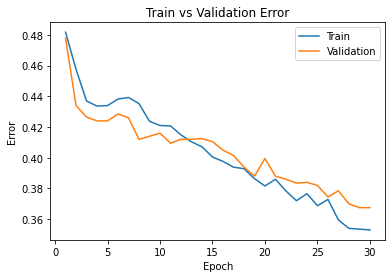

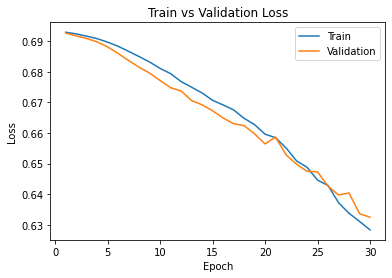

In [23]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
large_net_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_path)

# less time training time since for each iteration the time is shorter due to increase of batch size
# higher error and higher loss
# however the the model is not overfitting anymore.
# it seem s like the batch size is too large and we should decrease the batch size.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6776098045110702 |Validation err: 0.3745, Validation loss: 0.6529334635734558
Epoch 2: Train err: 0.368125, Train loss: 0.6402349994182587 |Validation err: 0.363, Validation loss: 0.6257380561828614
Epoch 3: Train err: 0.34525, Train loss: 0.6132398887872695 |Validation err: 0.35, Validation loss: 0.633517231464386
Epoch 4: Train err: 0.31475, Train loss: 0.5851500154137611 |Validation err: 0.3535, Validation loss: 0.6160770399570465
Epoch 5: Train err: 0.303875, Train loss: 0.5685942940711975 |Validation err: 0.3065, Validation loss: 0.5749539234638215
Epoch 6: Train err: 0.287125, Train loss: 0.5481366667151452 |Validation err: 0.3095, Validation loss: 0.5749097964763641
Epoch 7: Train err: 0.273625, Train loss: 0.5287300577163696 |Validation err: 0.318, Validation loss: 0.5926791634559632
Epoch 8: Train err: 0.26625, Train loss: 0.5114683332741261 |Validation err: 

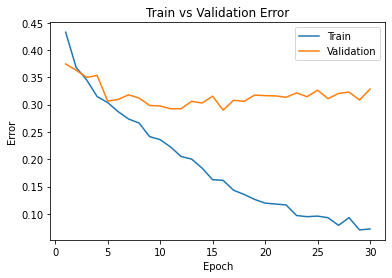

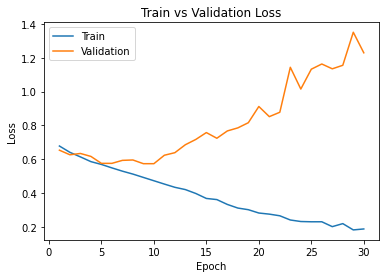

In [24]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
large_net_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_path)

# more time training time since for each iteration the time is longer due to decrease of batch size
# higher error and higher loss
# however the the model is overfitting more.
# it seem s like the batch size is too small and we should increase the batch size.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# hyperparameters (network = large_net, batch_size = 128, learning_rate = 0.01)
# for network, choose large_net since it has better performance
# for batch size, increase to 128 in order to make overfitting disappear
# for learning rate still choose 0.01

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454375, Train loss: 0.6920222469738552 |Validation err: 0.426, Validation loss: 0.6897578649222851
Epoch 2: Train err: 0.4445, Train loss: 0.6877972530940223 |Validation err: 0.411, Validation loss: 0.6820641942322254
Epoch 3: Train err: 0.4215, Train loss: 0.6812179968470619 |Validation err: 0.4115, Validation loss: 0.6738606616854668
Epoch 4: Train err: 0.409875, Train loss: 0.6737689517793202 |Validation err: 0.408, Validation loss: 0.6660398542881012
Epoch 5: Train err: 0.397125, Train loss: 0.6661053536430238 |Validation err: 0.402, Validation loss: 0.6589442789554596
Epoch 6: Train err: 0.37625, Train loss: 0.6566539473003812 |Validation err: 0.3885, Validation loss: 0.6511479429900646
Epoch 7: Train err: 0.37475, Train loss: 0.6487692812132457 |Validation err: 0.3765, Validation loss: 0.6394392438232899
Epoch 8: Train err: 0.3595, Train loss: 0.6364700084640866 |Validation err: 0.36

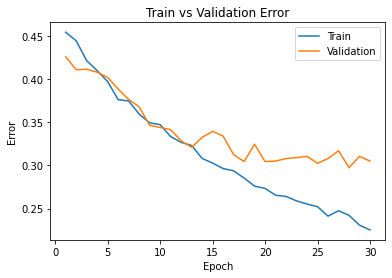

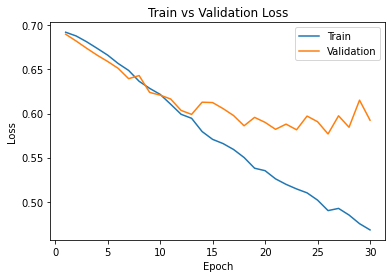

In [25]:
large_net = LargeNet()
train_net(large_net, 128, 0.01, 30)
large_net_path = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(large_net_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [41]:
# hyperparameters (network = large_net, batch_size = 128, learning_rate = 0.0075)

# since there are still overfitting and the loss and error is still a bit higher. 
# we decreate the learning rate a bit to 0.0075 to see if we can have better result.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.457, Train loss: 0.6923039006808448 |Validation err: 0.4265, Validation loss: 0.6907913498580456
Epoch 2: Train err: 0.44775, Train loss: 0.6896390735156952 |Validation err: 0.4215, Validation loss: 0.6856164522469044
Epoch 3: Train err: 0.427625, Train loss: 0.68494499108148 |Validation err: 0.415, Validation loss: 0.6790963523089886
Epoch 4: Train err: 0.420625, Train loss: 0.679194208175417 |Validation err: 0.407, Validation loss: 0.6716970838606358
Epoch 5: Train err: 0.413375, Train loss: 0.6737851245062692 |Validation err: 0.4085, Validation loss: 0.6672342494130135
Epoch 6: Train err: 0.398625, Train loss: 0.6677525109714932 |Validation err: 0.39, Validation loss: 0.663363628089428
Epoch 7: Train err: 0.388, Train loss: 0.6611566448968554 |Validation err: 0.3895, Validation loss: 0.6548199765384197
Epoch 8: Train err: 0.379875, Train loss: 0.6539502948049515 |Validation err: 0.3895,

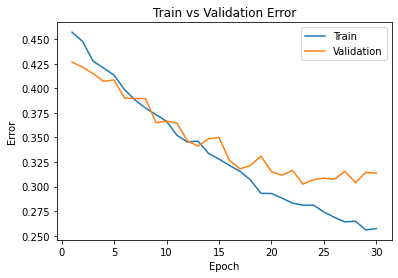

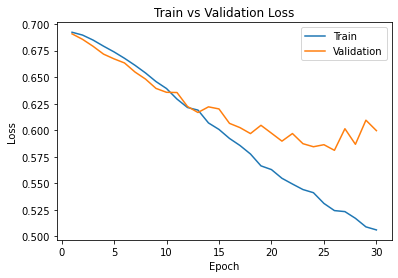

In [45]:
large_net = LargeNet()
train_net(large_net, 128, 0.0075, 30)
large_net_path = get_model_name("large", batch_size=128, learning_rate=0.0075, epoch=29)
plot_training_curve(large_net_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [49]:
large_net = LargeNet()
train_net(large_net, 128, 0.0075, 23)

state = torch.load(large_net_path)
large_net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48275, Train loss: 0.6928855843014188 |Validation err: 0.423, Validation loss: 0.6908150799572468
Epoch 2: Train err: 0.45, Train loss: 0.6904198243504479 |Validation err: 0.4185, Validation loss: 0.6863173395395279
Epoch 3: Train err: 0.44025, Train loss: 0.6859027270286803 |Validation err: 0.413, Validation loss: 0.6790668405592442
Epoch 4: Train err: 0.427375, Train loss: 0.6788986098198664 |Validation err: 0.3995, Validation loss: 0.6698238402605057
Epoch 5: Train err: 0.4025, Train loss: 0.671831606872498 |Validation err: 0.39, Validation loss: 0.6625180691480637
Epoch 6: Train err: 0.386, Train loss: 0.661790825071789 |Validation err: 0.3755, Validation loss: 0.6501830257475376
Epoch 7: Train err: 0.37575, Train loss: 0.650507492678506 |Validation err: 0.357, Validation loss: 0.6378122083842754
Epoch 8: Train err: 0.362, Train loss: 0.6386453111966451 |Validation err: 0.363, Validati

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [48]:
# Since there are overfitting after around 24th epoch, we only use 23 epochs in order to make the overfitting disappear 

# the validation error is 0.295 which is lower that the original error
# the validation loss is which is 0.5744 which is lower that the original loss

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [51]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
     batch_size = 128)

criterion_error = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(large_net, test_loader, criterion_error)
print("test classification error :", test_err)
print("test classification loss:", test_loss) 

Files already downloaded and verified
Files already downloaded and verified
test classification error : 0.295
test classification loss: 0.5727485120296478


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [53]:
# The test classification error is equal to the validation error.

# The validation data is used to evaluate the model and refine it during the development phase,
# while the test data is used to gauge the model's overall performance on unseen data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [52]:
#  If we use the test data throughout the development phase,
#  there is a risk of the model becoming too closely tied to the test data,
#  leading to an overestimation of its performance on new, unseen data.

# Using small amount test data can ensue our results are a fair and unbiased estimate of the model's performance on unseen data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422625, Train loss: 0.6744968811670939 |Validation err: 0.396, Validation loss: 0.6616230805714926
Epoch 2: Train err: 0.3845, Train loss: 0.6530806620915731 |Validation err: 0.3965, Validation loss: 0.6505541503429413
Epoch 3: Train err: 0.374125, Train loss: 0.6426623251703051 |Validation err: 0.384, Validation loss: 0.6467522631088892
Epoch 4: Train err: 0.36775, Train loss: 0.6354393455717299 |Validation err: 0.3875, Validation loss: 0.6469865143299103
Epoch 5: Train err: 0.36, Train loss: 0.6299164255460104 |Validation err: 0.379, Validation loss: 0.6490036596854528
Epoch 6: Train err: 0.348, Train loss: 0.6243362334039476 |Validation err: 0.3795, Validation loss: 0.6434867034355799
Epoch 7: Train err: 0.34025, Train loss: 0.6185624970330132 |Validation err: 0.3775, Validation loss: 0.6458980838457743
Epoch 8: Train err: 0.336625, Train loss: 0.6138979011111789 |Validation err: 0.3765

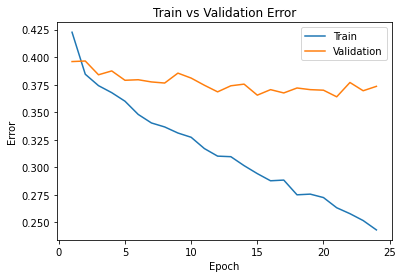

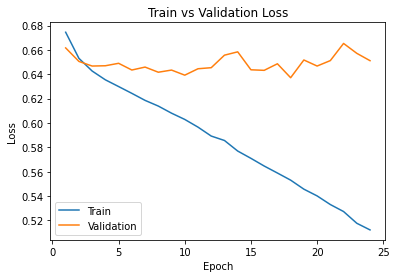

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 30)
        self.layer2 = nn.Linear(30, 1)
        self.name = "ANN"
    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

# change the model to ANN
ANN = Pigeon()
train_net(ANN, 180, 0.005, 24)

ANN_path = get_model_name("ANN", batch_size=180, learning_rate=0.005, epoch=23)
plot_training_curve(ANN_path)

In [86]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size = 128)

criterion_error = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ANN, test_loader, criterion_error)
print("test classification error :", test_err)
print("test classification loss:", test_loss) 

# As we can see the ANN model has larger test error and loss 
# So CNN model is better on classifying cat and dog images.

Files already downloaded and verified
Files already downloaded and verified
test classification error : 0.36
test classification loss: 0.6563664004206657
